### 상하좌우 반전 이미지 증식 적용
### ImageDataGenerator를 배우기 이전. 수동으로 증식 적용

In [1]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

### 이미지 전처리

In [9]:

"./plant-pathology-2020-fgvc7/images/"

IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "./plant-pathology-2020-fgvc7/sample_submission.csv"

test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    
    # 이미지 크기 확인
    height, width, _ = image.shape
    
    # 이미지 크기가 (2048, 1365)일 경우 회전하여 크기 변경
    if height == 2048 and width == 1365:
        image = np.rot90(image)

    # 이미지를 1/4 크기로 줄이기
    image = cv2.resize(image, (224, 224))
    
    image = image.astype('float32')/255

    return image

    #return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:].apply(load_image)



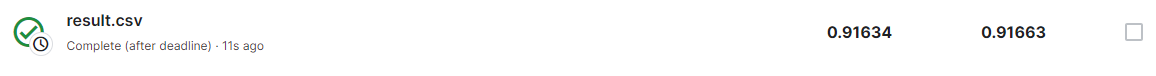

In [10]:
train_images2 = train_images.apply(lambda image: cv2.flip(image, 0))
train_images3 = train_images.apply(lambda image: cv2.flip(image, 1))
train_images4 = train_images.apply(lambda image: cv2.flip(image, -1))

In [11]:
train_images = np.stack(train_images)
train_images2 = np.stack(train_images2)
train_images3 = np.stack(train_images3)
train_images4 = np.stack(train_images4)

In [12]:
train_images = np.concatenate((train_images, train_images2, train_images3, train_images4), axis=0)

In [13]:
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values
labels = np.concatenate((labels, labels, labels, labels), axis=0)

In [14]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
"""
model = Sequential()
model.add(Conv2D(16, kernel_size=(3,3), input_shape=(512,341,3), activation='relu'))
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(4,4)))
#model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#model.add(Dropout(0.25))
#model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
#model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
"""

"\nmodel = Sequential()\nmodel.add(Conv2D(16, kernel_size=(3,3), input_shape=(512,341,3), activation='relu'))\n#model.add(Dropout(0.25))\nmodel.add(MaxPooling2D(pool_size=(4,4)))\n#model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))\n#model.add(Dropout(0.25))\n#model.add(MaxPooling2D(pool_size=(4,4)))\nmodel.add(Flatten())\n#model.add(Dropout(0.25))\nmodel.add(Dense(32, activation='relu'))\n#model.add(Dropout(0.1))\nmodel.add(Dense(16, activation='relu'))\n#model.add(Dropout(0.1))\nmodel.add(Dense(4, activation='softmax'))\n\nmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n"

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 53, 53, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 64)        

In [16]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# 데이터를 균등하게 분할하여 검증 세트를 생성
train_images, val_images, train_labels, val_labels = train_test_split(train_images, labels, test_size=0.2, stratify=labels)

# 학습에 사용할 데이터셋 준비
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(len(train_images)).batch(5)

# 검증에 사용할 데이터셋 준비
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(5)

# 학습 및 검증
modelpath = './test.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_dataset, epochs=70, verbose=1, callbacks=[early_stopping_callback, checkpointer], validation_data=val_dataset)

Epoch 1/70
1166/1166 [==============================] - ETA: 0s - loss: 1.2513 - accuracy: 0.3334
Epoch 1: val_loss improved from inf to 1.24033, saving model to .\test.hdf5
1166/1166 [==============================] - 11s 6ms/step - loss: 1.2513 - accuracy: 0.3334 - val_loss: 1.2403 - val_accuracy: 0.3418
Epoch 2/70
1155/1166 [============================>.] - ETA: 0s - loss: 1.2418 - accuracy: 0.3526
Epoch 2: val_loss did not improve from 1.24033
1166/1166 [==============================] - 5s 4ms/step - loss: 1.2415 - accuracy: 0.3520 - val_loss: 1.2432 - val_accuracy: 0.3418
Epoch 3/70
1164/1166 [============================>.] - ETA: 0s - loss: 0.9967 - accuracy: 0.5225
Epoch 3: val_loss improved from 1.24033 to 0.77763, saving model to .\test.hdf5
1166/1166 [==============================] - 5s 4ms/step - loss: 0.9961 - accuracy: 0.5227 - val_loss: 0.7776 - val_accuracy: 0.6362
Epoch 4/70
1156/1166 [============================>.] - ETA: 0s - loss: 0.6507 - accuracy: 0.7178
Epoch

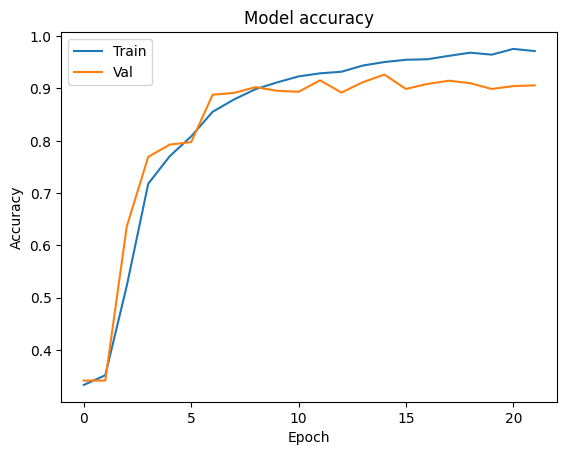

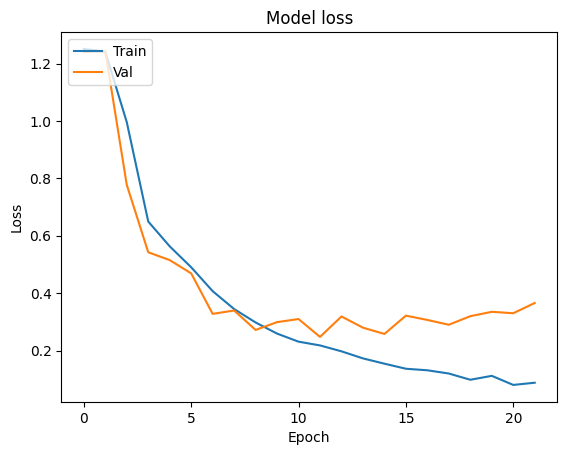

In [18]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 인터넷에서

### 인터넷에서 구한 전처리 방법

```python
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650),       # 1. 이미지 크기 조절 
    A.RandomBrightnessContrast(brightness_limit=0.2, # 2. 밝기 대비 조절
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p = 0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p = 0.5),  # 좌우 대칭 변환 
    A.ShiftScaleRotate(       # 3. 이동, 스케일링, 회전 변환
        shift_limit = 0.1,
        scale_limit = 0.2,
        rotate_limit = 30, p = 0.3),
    A.OneOf([A.Emboss(p = 1),   # 4. 양각화, 날카로움, 블러 효과
             A.Sharpen(p = 1),
             A.Blur(p = 1)], p = 0.3),
    A.PiecewiseAffine(p = 0.3), # 5. 어파인 변환 
    A.Normalize(),            # 6. 정규화 변환 
    ToTensorV2()              # 7. 텐서로 변환
])
```

1. Resize: 이미지 크기를 조절하는 변환기. 임의로 450x650 크기로 조절했다. 첫 번째 파라미터가 높이고, 두 번째가 너비다. 

 

2. RandomBrightnessContrast: 이미지의 밝기와 대비를 조절하는 변환기. 각 파라미터의 의미는 다음과 같다.

  - brightness_limit: 이미지 밝기 조절값을 설정. 0.2로 지정하였으므로 -0.2 ~ 0.2 범위의 밝기 조절자를 갖는다. 전체 범위는 -1~1로 -1이면 어둡게(검은색), 1이면 밝게(흰색) 변한다. 

  - contrast_limit: 이미지 대비 조절값을 설정한다. 동작 방식은 brightness_limit와 같다.

  - p: 적용 확률 설정. 0.3을 전달하였으므로 30%의 확률로 변환기를 적용한다는 의미다.

 

3. ShiftScaleRotate: 이동, 스케일링, 회전 변환기. 

- shift_limit: 이동 조절값  (0.1  -> -0.1~0.1)

- scale_limit: 스케일링 조절값  (0.2  -> -0.2~0.2)

- rotate_limit: 회전 각도 조절값  (30  -> -30~30)

 

4. Emboss(양각화 효과) / Sharpen(날카롭게 만드는 효과) / Blur(블러 효과) 중에서 한 개를 선택 적용.

 

5. PiecewiseAffine: 어파인 변환기. 어파인 변환이란 이동, 확대/축소, 회전 등으로 이미지 모양을 전체적으로 바꾸는 변환.

 

6. Normalize: 값을 정규화 한다.

 

7. ToTensorV2(): 이미지 데이터를 텐서 형식으로 변환.